In [8]:
import numpy as np
import time, os
import matplotlib.pyplot as plt
import multiprocessing as mp

In [19]:
class SoundController:
    # https://python-sounddevice.readthedocs.io/en/0.3.15/api/streams.html#sounddevice.OutputStream
    
    default_cfg = {
        'frequencies': [440, 880],
        'pulse_duration': 0.05,
        'sample_rate': 44100,
        'latency': 0.25,
        'volume': 0.75,
        'file_path': 'test_sound_log.csv',
    }
    
    @staticmethod
    def get_pure_tone(freq, duration, sample_rate=44100):
        x = np.linspace(0, duration * freq * 2*np.pi, int(duration*sample_rate), dtype=np.float32)
        return np.sin(x)
    
    @staticmethod
    def get_tone_stack(frequencies, pulse_duration, volume=0.75, sample_rate=44100):
        silence = np.zeros(2, dtype='float32')
        sounds = {0: np.column_stack((silence, silence))}

        for i, freq in enumerate(frequencies):
            # TODO add tone onset offset
            tone = SoundController.get_pure_tone(freq, pulse_duration, sample_rate) * volume           
            sounds[i + 1] = np.column_stack((tone, tone))
            
        return sounds
    
    @classmethod
    def run(cls, selector, status, cfg):
        """
        selector        mp.Value object to set the sound to be played
        status          mp.Value object to stop the loop
        """
        import sounddevice as sd  # must be inside the function

        sounds = cls.get_tone_stack(cfg['frequencies'], cfg['pulse_duration'])

        sd.default.samplerate = cfg['sample_rate']
        stream = sd.OutputStream(samplerate=cfg['sample_rate'], channels=2, dtype='float32', blocksize=256)
        stream.start()

        next_beat = time.time() + cfg['latency']
        with open(cfg['file_path'], 'w') as f:
            f.write("time,id\n")

        while status.value > 0:
            if status.value == 2:  # running state
                t0 = time.time()
                if t0 < next_beat:
                    #time.sleep(0.0001)  # not to spin the wheels too much
                    if stream.write_available > 2:
                        stream.write(sounds[0])  # silence
                    continue

                stream.write(sounds[int(selector.value)])
                with open(cfg['file_path'], 'a') as f:
                    f.write(",".join([str(x) for x in (t0, selector.value)]) + "\n")

                next_beat += cfg['latency']
                
                if stream.write_available > 2:
                    stream.write(sounds[0])  # silence
            
            else:  # idle state
                next_beat = time.time() + cfg['latency']
                time.sleep(0.05)
                
        stream.stop()
        print('Sound stopped')

### Testing sound pulses

In [20]:
# sound selector: 0 - silence, 1 - tone 1, 2 - tone 2
selector = mp.Value('i', 1)

# loggin status: 1 - idle, 2 - running, 0 - stopped
status = mp.Value('i', 1)

sc = mp.Process(target=SoundController.run, args=(selector, status, SoundController.default_cfg))
sc.start()

# nothing happens for a second
time.sleep(1)

# 2 seconds of tone 1
status.value = 2
time.sleep(2)

# 2 seconds of tone 2
selector.value = 2
time.sleep(2)

# stop
status.value = 0
time.sleep(0.2)
sc.join()

Sound stopped


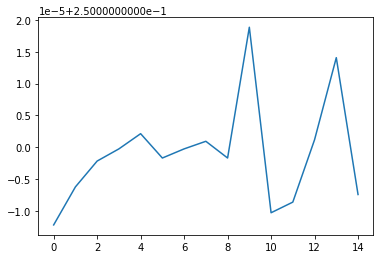

In [21]:
ds = np.loadtxt('test_sound_log.csv', delimiter=',', skiprows=1)
plt.plot(np.diff(ds[:, 0]))

In [27]:
10 * np.random.rand()

6.945724898237127